# Metadata

```yaml
Course:    DS 5001
Module:    10 Lab
Topic:     Combine Lexicons
Author:    R.C. Alvarado
Date:      02 April 2023 (revised)
```

**Purpose:** Collect all lexicons into a single database.

# Set Up

In [1]:
data_in = '../data'

In [2]:
bing_pos_file = data_in + '/lexicons/sources/opinion-lexicon-English/positive-words.txt'
bing_neg_file = data_in + '/lexicons/sources/opinion-lexicon-English/negative-words.txt'
nrc_file = data_in + "/lexicons/sources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
syuzhet_file = data_in + "/lexicons/sources/syuzhet.csv"
gi_file = data_in + "/lexicons/sources/gi.csv"

In [3]:
import sqlite3
import pandas as pd
import re

# Import Bing lexicon

First, download RAR file from [here](http://sentiment.christopherpotts.net/lexicons.html#opinionlexicon).  Then open in a text editor and convert encoding and line endings in an editor.

In [5]:
bing_list = [(word.strip(), 'bing_positive', 1) 
             for word in open(bing_pos_file, 'r').readlines() 
             if re.match(r'^\w+$', word)]

In [6]:
bing_list += [(word.strip(), 'bing_negative', 1) 
              for word in open(bing_neg_file, 'r').readlines() 
              if re.match(r'^\w+$', word)]

In [9]:
bing = pd.DataFrame(bing_list, columns=['term_str', 'polarity', 'val'])
bing = bing.set_index(['term_str','polarity'])
bing = bing.unstack().fillna(0).astype('int')
bing.columns = bing.columns.droplevel(0)

In [10]:
bing.sum()

polarity
bing_negative    4659
bing_positive    1904
dtype: int64

## Create single sentiment column

In [11]:
bing['bing_sentiment'] = bing['bing_positive'] - bing['bing_negative']

In [12]:
bing.sample(10)

polarity,bing_negative,bing_positive,bing_sentiment
term_str,,,
loud,1,0,-1
inept,1,0,-1
comical,1,0,-1
restricted,1,0,-1
improvements,0,1,1
weaken,1,0,-1
hypocritically,1,0,-1
blabber,1,0,-1
reputation,0,1,1


# Import NRC lexicon

In [13]:
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]

In [14]:
nrc.sum().sort_values(ascending=False)

nrc_negative        2366
nrc_fear            1368
nrc_positive        1281
nrc_anger           1208
nrc_sadness         1137
nrc_disgust         1004
nrc_trust            935
nrc_joy              686
nrc_anticipation     682
nrc_surprise         454
dtype: int64

In [15]:
nrc.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
term_str,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0
abduction,0,0,0,1,0,1,0,1,1,0
aberration,0,0,1,0,0,1,0,0,0,0


In [24]:
nrc['nrc_sentiment'] =nrc.nrc_positive - nrc.nrc_negative

In [26]:
nrc['nrc_sentiment'].sample(10)

term_str
dismemberment   -1
arid            -1
oasis            1
clearance        1
basketball       1
misplace        -1
disheartened    -1
celebrity        0
loathsome       -1
abortive        -1
Name: nrc_sentiment, dtype: int64

# Import Syuzhet lexicon

In [27]:
syu = pd.read_csv(syuzhet_file)
syu.columns = ['id','term_str','syu_sentiment']
syu = syu.drop('id', axis=1)
syu = syu.set_index('term_str')

In [28]:
syu.head()

,syu_sentiment
term_str,
abandon,-0.75
abandoned,-0.50
abandoner,-0.25
abandonment,-0.25
abandons,-1.00


# Import General Inquirer lexicon

This is prepared in a separate notebook.

In [33]:
gi = pd.read_csv(gi_file, index_col=['term_str'])
gi.columns = ['gi_sentiment']

In [34]:
gi.head()

,gi_sentiment
term_str,
abandon,-1
abandonment,-1
abate,-1
abdicate,-1
abhor,-1


# Combine all

In [35]:
combo = nrc.join(bing, how='outer')\
    .join(syu, how='outer')\
    .join(gi, how='outer')\
    .sort_index()

In [37]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_sentiment,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


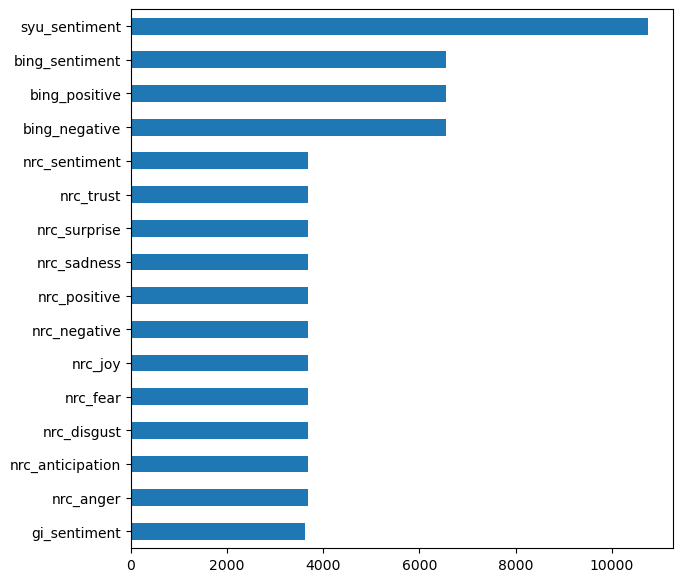

In [38]:
combo.count().sort_values().plot(kind='barh', figsize=(7,7));

# Save

In [39]:
nrc.to_csv(data_in + '/lexicons/salex_nrc.csv')
bing.to_csv(data_in + '/lexicons/salex_bing.csv')
syu.to_csv(data_in + '/lexicons/salex_syuzhet.csv')
gi.to_csv(data_in + '/lexicons/salex_gi.csv')
combo.to_csv(data_in + '/lexicons/salex_combo.csv')        